## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp028'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.9),
        A.RandomBrightnessContrast(p=0.9),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.9),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.9),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

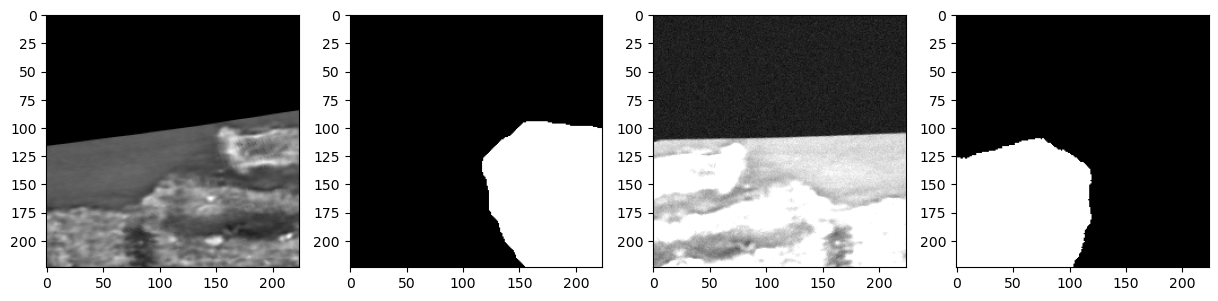

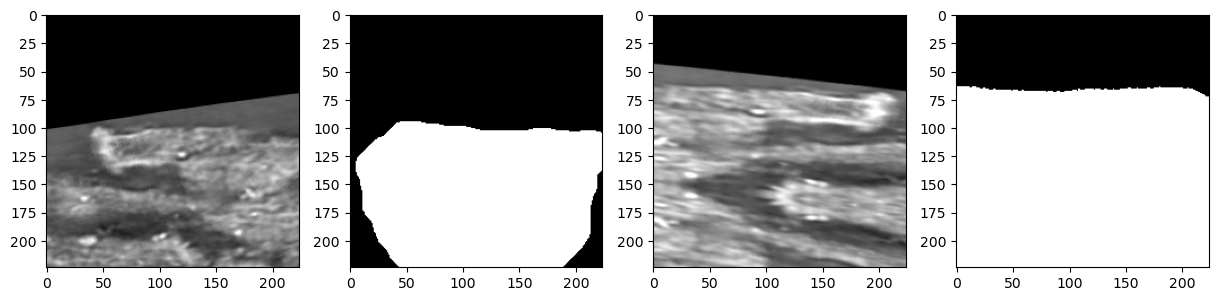

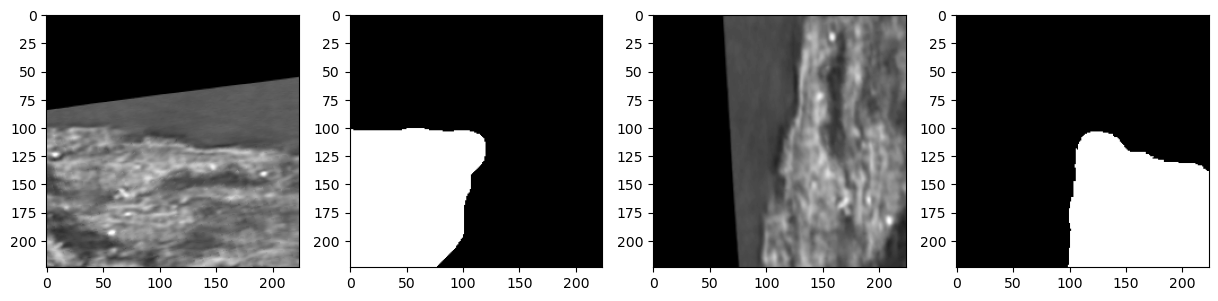

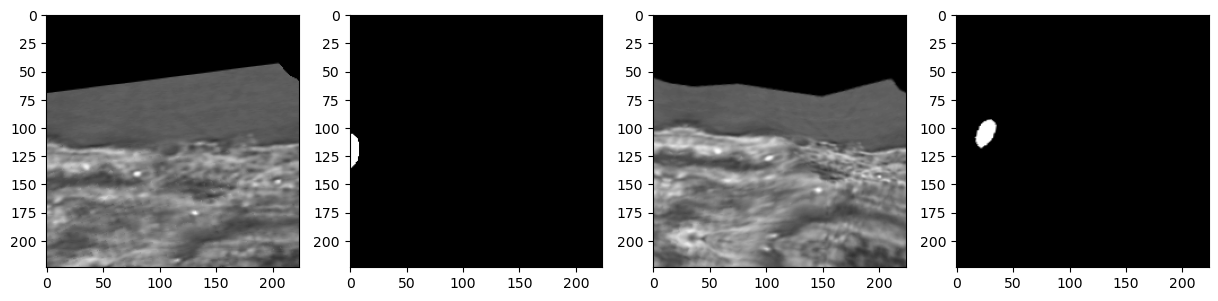

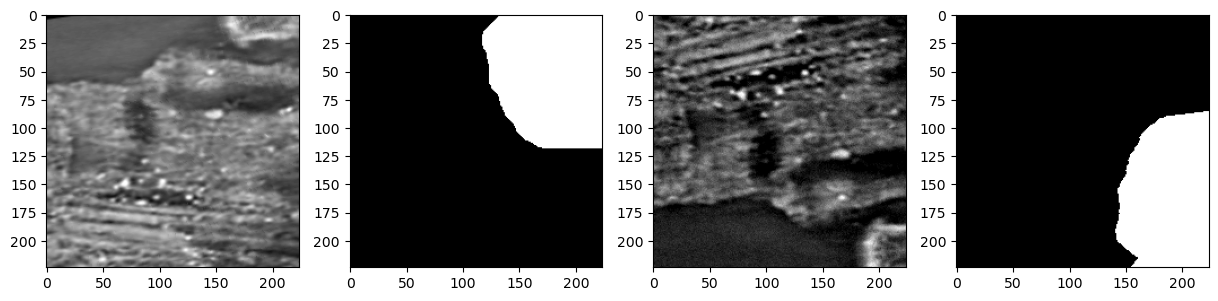

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48150

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.09501349873478501
th: 0.15, fbeta: 0.09504603465951891
th: 0.2, fbeta: 0.1209569458314397
th: 0.25, fbeta: 0.15815361414299653
th: 0.3, fbeta: 0.19868850322711037
th: 0.35, fbeta: 0.25254325288677165
th: 0.4, fbeta: 0.29560586529569305
th: 0.45, fbeta: 0.3271882920899379


best_th: 0.5, fbeta: 0.3523749282044281
Epoch 1 - avg_train_loss: 0.5672  avg_val_loss: 0.4016  time: 169s
Epoch 1 - avgScore: 0.3524
Epoch 1 - Save Best Score: 0.3524 Model
Epoch 1 - Save Best Loss: 0.4016 Model


th: 0.5, fbeta: 0.3523749282044281


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1014060600579147
th: 0.15, fbeta: 0.15407865036424406
th: 0.2, fbeta: 0.17798778853508723
th: 0.25, fbeta: 0.29144277613997666
th: 0.3, fbeta: 0.3383030882966452
th: 0.35, fbeta: 0.3746126055509354
th: 0.4, fbeta: 0.4044424860513688
th: 0.45, fbeta: 0.4335111525541391


best_th: 0.5, fbeta: 0.4371198089915098
Epoch 2 - avg_train_loss: 0.3743  avg_val_loss: 0.2968  time: 172s
Epoch 2 - avgScore: 0.4371
Epoch 2 - Save Best Score: 0.4371 Model
Epoch 2 - Save Best Loss: 0.2968 Model


th: 0.5, fbeta: 0.4371198089915098


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.2559147128590204
th: 0.15, fbeta: 0.3745259844186676
th: 0.2, fbeta: 0.4581219789695502
th: 0.25, fbeta: 0.4995390922635925
th: 0.3, fbeta: 0.5101818331044526
th: 0.35, fbeta: 0.5057379454107064
th: 0.4, fbeta: 0.4890423313122372
th: 0.45, fbeta: 0.46426853106787064


best_th: 0.3, fbeta: 0.5101818331044526
Epoch 3 - avg_train_loss: 0.2994  avg_val_loss: 0.2017  time: 173s
Epoch 3 - avgScore: 0.5102
Epoch 3 - Save Best Score: 0.5102 Model
Epoch 3 - Save Best Loss: 0.2017 Model


th: 0.5, fbeta: 0.41575459151163274


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29182137887137555
th: 0.15, fbeta: 0.37037224918842865
th: 0.2, fbeta: 0.4315662343586127
th: 0.25, fbeta: 0.47825067741778776
th: 0.3, fbeta: 0.5120017963538793
th: 0.35, fbeta: 0.5391190560349679
th: 0.4, fbeta: 0.5566520360686442
th: 0.45, fbeta: 0.5643656294651315


best_th: 0.45, fbeta: 0.5643656294651315
Epoch 4 - avg_train_loss: 0.2714  avg_val_loss: 0.1910  time: 173s
Epoch 4 - avgScore: 0.5644
Epoch 4 - Save Best Score: 0.5644 Model
Epoch 4 - Save Best Loss: 0.1910 Model


th: 0.5, fbeta: 0.5563411993329209


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.344957111274057
th: 0.15, fbeta: 0.41067156877373273
th: 0.2, fbeta: 0.4628734588235905
th: 0.25, fbeta: 0.5028901870673491
th: 0.3, fbeta: 0.5343307206277439
th: 0.35, fbeta: 0.5572798201263018
th: 0.4, fbeta: 0.5744781661207145


best_th: 0.45, fbeta: 0.5769900201082369
Epoch 5 - avg_train_loss: 0.2576  avg_val_loss: 0.1880  time: 173s
Epoch 5 - avgScore: 0.5770
Epoch 5 - Save Best Score: 0.5770 Model
Epoch 5 - Save Best Loss: 0.1880 Model


th: 0.45, fbeta: 0.5769900201082369
th: 0.5, fbeta: 0.5436676838127492


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.20479749813978837
th: 0.15, fbeta: 0.2381327278834356
th: 0.2, fbeta: 0.26767205735107363
th: 0.25, fbeta: 0.295654407645724
th: 0.3, fbeta: 0.32255593836465346
th: 0.35, fbeta: 0.3501224255519224
th: 0.4, fbeta: 0.37814670664038286


best_th: 0.5, fbeta: 0.4310611678733775
Epoch 6 - avg_train_loss: 0.2494  avg_val_loss: 0.2454  time: 173s
Epoch 6 - avgScore: 0.4311


th: 0.45, fbeta: 0.40554878486816137
th: 0.5, fbeta: 0.4310611678733775


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.25983659845673696
th: 0.15, fbeta: 0.3055949655882255
th: 0.2, fbeta: 0.3445131596775548
th: 0.25, fbeta: 0.37472711985340895
th: 0.3, fbeta: 0.40478919009460884
th: 0.35, fbeta: 0.4367572553487056
th: 0.4, fbeta: 0.4661753012344987
th: 0.45, fbeta: 0.48984246968060585


best_th: 0.5, fbeta: 0.512023885617664
Epoch 7 - avg_train_loss: 0.2391  avg_val_loss: 0.2031  time: 173s
Epoch 7 - avgScore: 0.5120


th: 0.5, fbeta: 0.512023885617664


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3086800761778599
th: 0.15, fbeta: 0.35912969654415794
th: 0.2, fbeta: 0.4057368709749449
th: 0.25, fbeta: 0.44429247671792005
th: 0.3, fbeta: 0.47806242854293257
th: 0.35, fbeta: 0.5081310281727822
th: 0.4, fbeta: 0.5332322546475259
th: 0.45, fbeta: 0.5506344064928265


best_th: 0.5, fbeta: 0.560080153436355
Epoch 8 - avg_train_loss: 0.2319  avg_val_loss: 0.1882  time: 173s
Epoch 8 - avgScore: 0.5601


th: 0.5, fbeta: 0.560080153436355


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2810419491389768
th: 0.15, fbeta: 0.34287740630695857
th: 0.2, fbeta: 0.3934194978955388
th: 0.25, fbeta: 0.43740202445625426
th: 0.3, fbeta: 0.4736315584162723
th: 0.35, fbeta: 0.5056900711698155
th: 0.4, fbeta: 0.5355323163182716


best_th: 0.5, fbeta: 0.5735552039327028
Epoch 9 - avg_train_loss: 0.2241  avg_val_loss: 0.1891  time: 173s
Epoch 9 - avgScore: 0.5736


th: 0.45, fbeta: 0.5579381739550094
th: 0.5, fbeta: 0.5735552039327028


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33639104880276394
th: 0.15, fbeta: 0.395219744077009
th: 0.2, fbeta: 0.44551689282911006
th: 0.25, fbeta: 0.48900519788016744
th: 0.3, fbeta: 0.523667451477093
th: 0.35, fbeta: 0.5543942521343836
th: 0.4, fbeta: 0.5638378780868671
th: 0.45, fbeta: 0.5571515463789415


best_th: 0.4, fbeta: 0.5638378780868671
Epoch 10 - avg_train_loss: 0.2141  avg_val_loss: 0.1887  time: 174s
Epoch 10 - avgScore: 0.5638


th: 0.5, fbeta: 0.5419933156951682


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36808796059685533
th: 0.15, fbeta: 0.4443570806391186
th: 0.2, fbeta: 0.4965253411605083
th: 0.25, fbeta: 0.5356676286998494
th: 0.3, fbeta: 0.5572805363862847
th: 0.35, fbeta: 0.5706323370029898
th: 0.4, fbeta: 0.5789247219854261
th: 0.45, fbeta: 0.5820210829598654


best_th: 0.5, fbeta: 0.582687729573801
Epoch 11 - avg_train_loss: 0.2047  avg_val_loss: 0.1864  time: 173s
Epoch 11 - avgScore: 0.5827
Epoch 11 - Save Best Score: 0.5827 Model
Epoch 11 - Save Best Loss: 0.1864 Model


th: 0.5, fbeta: 0.582687729573801


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35679982979297437
th: 0.15, fbeta: 0.41011457012460995
th: 0.2, fbeta: 0.4602960433320665
th: 0.25, fbeta: 0.5009657764041645
th: 0.3, fbeta: 0.534876290234028
th: 0.35, fbeta: 0.5578799952895035
th: 0.4, fbeta: 0.5723089212362108


best_th: 0.45, fbeta: 0.5780894110386042
Epoch 12 - avg_train_loss: 0.1969  avg_val_loss: 0.1902  time: 173s
Epoch 12 - avgScore: 0.5781


th: 0.45, fbeta: 0.5780894110386042
th: 0.5, fbeta: 0.5746805340806


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2797520408947793
th: 0.15, fbeta: 0.31951427762765583
th: 0.2, fbeta: 0.3547024417660989
th: 0.25, fbeta: 0.3830850490460592
th: 0.3, fbeta: 0.40782274445612904
th: 0.35, fbeta: 0.4284682270550128
th: 0.4, fbeta: 0.44977451884595365
th: 0.45, fbeta: 0.4702800716513829


best_th: 0.5, fbeta: 0.48982541531143436
Epoch 13 - avg_train_loss: 0.1889  avg_val_loss: 0.2174  time: 172s
Epoch 13 - avgScore: 0.4898


th: 0.5, fbeta: 0.48982541531143436


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.28690787059947603
th: 0.15, fbeta: 0.32605171483557494
th: 0.2, fbeta: 0.35883880485329206
th: 0.25, fbeta: 0.3890550810214294
th: 0.3, fbeta: 0.41435114814184415
th: 0.35, fbeta: 0.4383219579799791
th: 0.4, fbeta: 0.45859652719618677
th: 0.45, fbeta: 0.47457646365682365


best_th: 0.5, fbeta: 0.49073293139670277
Epoch 14 - avg_train_loss: 0.1831  avg_val_loss: 0.2172  time: 173s
Epoch 14 - avgScore: 0.4907


th: 0.5, fbeta: 0.49073293139670277


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3829663495948533
th: 0.15, fbeta: 0.4279568182338079
th: 0.2, fbeta: 0.4620939087509721
th: 0.25, fbeta: 0.48849878655696877
th: 0.3, fbeta: 0.5099521794283755
th: 0.35, fbeta: 0.5251817857016048
th: 0.4, fbeta: 0.5356213264341834
th: 0.45, fbeta: 0.5401120175722001


best_th: 0.5, fbeta: 0.5408615437538487
Epoch 15 - avg_train_loss: 0.1733  avg_val_loss: 0.2047  time: 173s
Epoch 15 - avgScore: 0.5409


th: 0.5, fbeta: 0.5408615437538487


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32632777446326366
th: 0.15, fbeta: 0.36904647297294935
th: 0.2, fbeta: 0.40464477669429544
th: 0.25, fbeta: 0.4366671700518153
th: 0.3, fbeta: 0.46793569044713684
th: 0.35, fbeta: 0.4935261650042793
th: 0.4, fbeta: 0.5144758536921712
th: 0.45, fbeta: 0.5328717714692259


best_th: 0.5, fbeta: 0.5484231176801234
Epoch 16 - avg_train_loss: 0.1688  avg_val_loss: 0.2112  time: 172s
Epoch 16 - avgScore: 0.5484


th: 0.5, fbeta: 0.5484231176801234


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3912760910213506
th: 0.15, fbeta: 0.44772509589062987
th: 0.2, fbeta: 0.4904851111848656
th: 0.25, fbeta: 0.5213326725164317
th: 0.3, fbeta: 0.5424407868116786
th: 0.35, fbeta: 0.550801299587964
th: 0.4, fbeta: 0.550058212822597
th: 0.45, fbeta: 0.5526205731184767


best_th: 0.45, fbeta: 0.5526205731184767
Epoch 17 - avg_train_loss: 0.1587  avg_val_loss: 0.2042  time: 172s
Epoch 17 - avgScore: 0.5526


th: 0.5, fbeta: 0.5516741024615238


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40642917201935813
th: 0.15, fbeta: 0.4528596928890146
th: 0.2, fbeta: 0.48827459883486557
th: 0.25, fbeta: 0.5177949862737148
th: 0.3, fbeta: 0.5384576331963817
th: 0.35, fbeta: 0.5522957168523066
th: 0.4, fbeta: 0.5614542257634869
th: 0.45, fbeta: 0.5638658641012549


best_th: 0.45, fbeta: 0.5638658641012549
Epoch 18 - avg_train_loss: 0.1537  avg_val_loss: 0.2093  time: 172s
Epoch 18 - avgScore: 0.5639


th: 0.5, fbeta: 0.562670528592065


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31953317888261146
th: 0.15, fbeta: 0.3587352412056556
th: 0.2, fbeta: 0.39041789937887433
th: 0.25, fbeta: 0.4165328392568221
th: 0.3, fbeta: 0.4455509205314912
th: 0.35, fbeta: 0.4750627415664454
th: 0.4, fbeta: 0.4989149964850899


best_th: 0.5, fbeta: 0.5371555794680901
Epoch 19 - avg_train_loss: 0.1511  avg_val_loss: 0.2107  time: 172s
Epoch 19 - avgScore: 0.5372


th: 0.45, fbeta: 0.5184307798697358
th: 0.5, fbeta: 0.5371555794680901


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.343101982243914
th: 0.15, fbeta: 0.38108652048922903
th: 0.2, fbeta: 0.40943198686920695
th: 0.25, fbeta: 0.4348947674212775
th: 0.3, fbeta: 0.4593403549613934
th: 0.35, fbeta: 0.4835923411451762
th: 0.4, fbeta: 0.5045435890506135
th: 0.45, fbeta: 0.5253230590345312


best_th: 0.5, fbeta: 0.542826594436272
Epoch 20 - avg_train_loss: 0.1402  avg_val_loss: 0.2224  time: 171s
Epoch 20 - avgScore: 0.5428


th: 0.5, fbeta: 0.542826594436272


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3227904867345773
th: 0.15, fbeta: 0.3576518951464808
th: 0.2, fbeta: 0.3876081997981211
th: 0.25, fbeta: 0.4144508173719519
th: 0.3, fbeta: 0.43745938221871444
th: 0.35, fbeta: 0.46189795373428744
th: 0.4, fbeta: 0.48468240284271874
th: 0.45, fbeta: 0.5012067273387238


best_th: 0.5, fbeta: 0.515627461641934
Epoch 21 - avg_train_loss: 0.1338  avg_val_loss: 0.2351  time: 172s
Epoch 21 - avgScore: 0.5156


th: 0.5, fbeta: 0.515627461641934


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29670041588302
th: 0.15, fbeta: 0.3252704880657788
th: 0.2, fbeta: 0.3487748336760621
th: 0.25, fbeta: 0.37107277872002786
th: 0.3, fbeta: 0.3931359588915758
th: 0.35, fbeta: 0.41081653954435815
th: 0.4, fbeta: 0.42908477886460533
th: 0.45, fbeta: 0.4452076611461775


best_th: 0.5, fbeta: 0.4595952948330051
Epoch 22 - avg_train_loss: 0.1280  avg_val_loss: 0.2522  time: 172s
Epoch 22 - avgScore: 0.4596


th: 0.5, fbeta: 0.4595952948330051


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.319463496330674
th: 0.15, fbeta: 0.35472390738621856
th: 0.2, fbeta: 0.38302102964966317
th: 0.25, fbeta: 0.40698856047985826
th: 0.3, fbeta: 0.42874017887402127
th: 0.35, fbeta: 0.4457520667770904
th: 0.4, fbeta: 0.4618416696695561
th: 0.45, fbeta: 0.476154498008148


best_th: 0.5, fbeta: 0.4911857917443385
Epoch 23 - avg_train_loss: 0.1261  avg_val_loss: 0.2373  time: 171s
Epoch 23 - avgScore: 0.4912


th: 0.5, fbeta: 0.4911857917443385


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3310779048146243
th: 0.15, fbeta: 0.36165357490513217
th: 0.2, fbeta: 0.3888668109979788
th: 0.25, fbeta: 0.4144120909107093
th: 0.3, fbeta: 0.44157451080964605
th: 0.35, fbeta: 0.4654219494475885
th: 0.4, fbeta: 0.4833509269790534


best_th: 0.5, fbeta: 0.5106801742723268
Epoch 24 - avg_train_loss: 0.1205  avg_val_loss: 0.2281  time: 172s
Epoch 24 - avgScore: 0.5107


th: 0.45, fbeta: 0.49779521912394437
th: 0.5, fbeta: 0.5106801742723268


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3371521714794369
th: 0.15, fbeta: 0.3712376851293076
th: 0.2, fbeta: 0.400893447169766
th: 0.25, fbeta: 0.4273225761463968
th: 0.3, fbeta: 0.45006472856408675
th: 0.35, fbeta: 0.46987593548115986
th: 0.4, fbeta: 0.4847521607039743


best_th: 0.5, fbeta: 0.5140172800720971
Epoch 25 - avg_train_loss: 0.1177  avg_val_loss: 0.2367  time: 171s
Epoch 25 - avgScore: 0.5140


th: 0.45, fbeta: 0.5003509883011241
th: 0.5, fbeta: 0.5140172800720971


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3184749835209033
th: 0.15, fbeta: 0.3481436963763275
th: 0.2, fbeta: 0.3748608102096361
th: 0.25, fbeta: 0.3978818465823769
th: 0.3, fbeta: 0.41919687065849803
th: 0.35, fbeta: 0.4392843238302522
th: 0.4, fbeta: 0.4590883037279267
th: 0.45, fbeta: 0.4764358887217986


best_th: 0.5, fbeta: 0.4893368682968965
Epoch 26 - avg_train_loss: 0.1157  avg_val_loss: 0.2474  time: 171s
Epoch 26 - avgScore: 0.4893


th: 0.5, fbeta: 0.4893368682968965


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33960286820750274
th: 0.15, fbeta: 0.3728038511981117
th: 0.2, fbeta: 0.4004303369570541
th: 0.25, fbeta: 0.4287899066419951
th: 0.3, fbeta: 0.4527559161964349
th: 0.35, fbeta: 0.47289018535845767
th: 0.4, fbeta: 0.48948593079882136
th: 0.45, fbeta: 0.503995458652437


best_th: 0.5, fbeta: 0.5151552269527899
Epoch 27 - avg_train_loss: 0.1122  avg_val_loss: 0.2340  time: 172s
Epoch 27 - avgScore: 0.5152


th: 0.5, fbeta: 0.5151552269527899


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31416535190327555
th: 0.15, fbeta: 0.3436762231946646
th: 0.2, fbeta: 0.36894287962707356
th: 0.25, fbeta: 0.3951329147368527
th: 0.3, fbeta: 0.4192936352342091
th: 0.35, fbeta: 0.44248781636677803
th: 0.4, fbeta: 0.4620411365647287
th: 0.45, fbeta: 0.4818179535751906


best_th: 0.5, fbeta: 0.49532524450485976
Epoch 28 - avg_train_loss: 0.1117  avg_val_loss: 0.2428  time: 171s
Epoch 28 - avgScore: 0.4953


th: 0.5, fbeta: 0.49532524450485976


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3344576648365647
th: 0.15, fbeta: 0.36422169664860343
th: 0.2, fbeta: 0.39133724863677044
th: 0.25, fbeta: 0.41648238698899975
th: 0.3, fbeta: 0.43886825147776354
th: 0.35, fbeta: 0.45861107427498343
th: 0.4, fbeta: 0.47424915846626026
th: 0.45, fbeta: 0.4868601639950746


best_th: 0.5, fbeta: 0.49865409298671404
Epoch 29 - avg_train_loss: 0.1080  avg_val_loss: 0.2443  time: 172s
Epoch 29 - avgScore: 0.4987


th: 0.5, fbeta: 0.49865409298671404


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31769470308983405
th: 0.15, fbeta: 0.34733972509080363
th: 0.2, fbeta: 0.3715568821032384
th: 0.25, fbeta: 0.3976566951653135
th: 0.3, fbeta: 0.42073541139503906
th: 0.35, fbeta: 0.44408024833621934
th: 0.4, fbeta: 0.46455619785354973
th: 0.45, fbeta: 0.47989944899397785


best_th: 0.5, fbeta: 0.49259261252043485
Epoch 30 - avg_train_loss: 0.1073  avg_val_loss: 0.2489  time: 172s
Epoch 30 - avgScore: 0.4926


th: 0.5, fbeta: 0.49259261252043485


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.36808796059685533
th: 0.15, fbeta: 0.4443570806391186
th: 0.2, fbeta: 0.4965253411605083
th: 0.25, fbeta: 0.5356676286998494
th: 0.3, fbeta: 0.5572805363862847
th: 0.35, fbeta: 0.5706323370029898
th: 0.4, fbeta: 0.5789247219854261


best_th: 0.5, fbeta: 0.582687729573801


th: 0.45, fbeta: 0.5820210829598654
th: 0.5, fbeta: 0.582687729573801


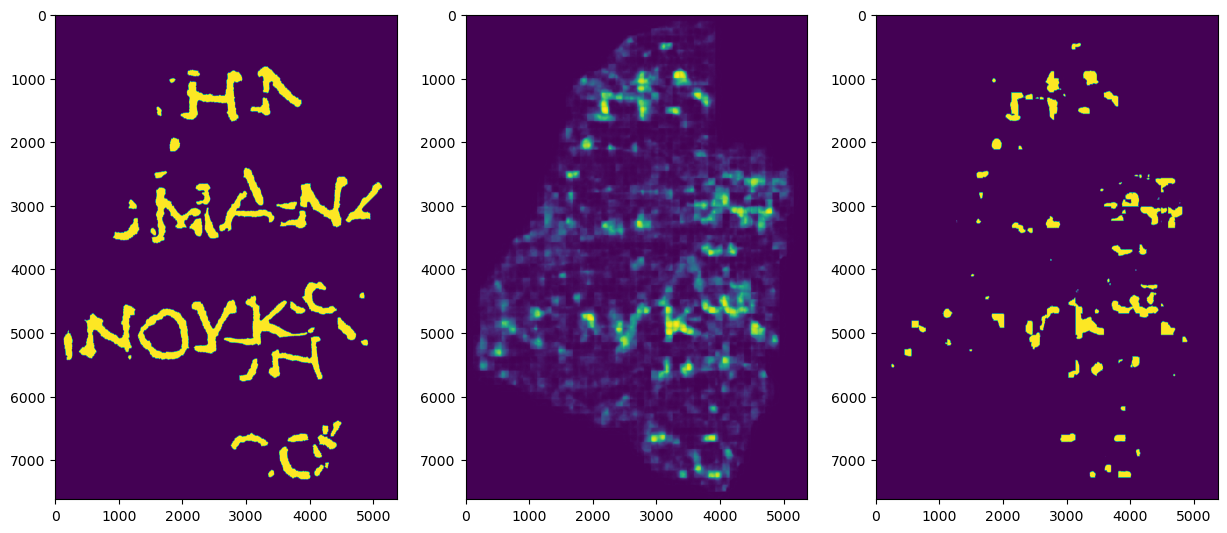

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([28857785.,  4749119.,  2195205.,  1191424.,   765852.,   551553.,
          448064.,   359311.,   281291.,   241302.,   208880.,   192031.,
          176243.,   152567.,   139702.,   119720.,   102018.,    99147.,
           73743.,    38659.]),
 array([6.32684605e-05, 4.90390425e-02, 9.80148164e-02, 1.46990590e-01,
        1.95966364e-01, 2.44942138e-01, 2.93917912e-01, 3.42893686e-01,
        3.91869460e-01, 4.40845234e-01, 4.89821008e-01, 5.38796782e-01,
        5.87772556e-01, 6.36748330e-01, 6.85724104e-01, 7.34699878e-01,
        7.83675652e-01, 8.32651426e-01, 8.81627200e-01, 9.30602974e-01,
        9.79578748e-01]),
 <BarContainer object of 20 artists>)

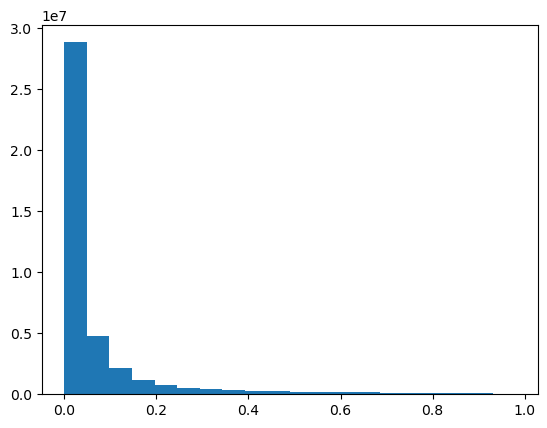

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000